In [10]:
import wfdb
import matplotlib.pyplot as plt
import contextlib
import os
# Create a DataFrame for visualization
import pandas as pd
import numpy as np
import seaborn as sns
import csv

print(wfdb.__version__)

4.1.2


Record Name: 100
Sampling Frequency: 360 Hz
Number of Channels: 2
Signal Length: 650000 samples


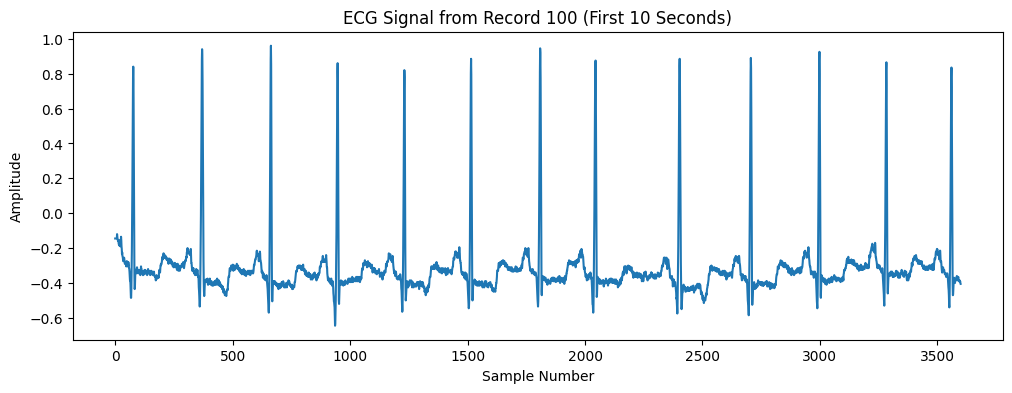

In [2]:
# Load record '100' from the MIT-BIH dataset
filename = '100'
record = wfdb.rdrecord(filename)

# Access waveform data for channel 0 (ECG signal)
signal = record.p_signal[:, 0]

# Access sampling frequency
fs = record.fs

# Print basic information about the record
print(f"Record Name: {record.record_name}")
print(f"Sampling Frequency: {fs} Hz")
print(f"Number of Channels: {record.n_sig}")
print(f"Signal Length: {len(signal)} samples")

# Calculate the number of samples for the first 10 seconds
duration_in_seconds = 10
num_samples = duration_in_seconds * fs

# Extract the first 10 seconds of the signal
zoomed_signal = signal[:num_samples]

# Plot the first 10 seconds
plt.figure(figsize=(12, 4))
plt.plot(zoomed_signal)
plt.title(f'ECG Signal from Record {filename} (First {duration_in_seconds} Seconds)')
plt.xlabel('Sample Number')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
def write_to_csv(flat_segments, csv_file_path):
    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Record', 'Total flat segments', 'Total flat segments > 100ms', 'Average duration (ms)', 'Longest flat segment (ms)', 'Shortest flat segment (ms)'])
        for segment in flat_segments:
            csv_writer.writerow(segment)
def detect_flat_lines(filename):
    # Load the record
    record = wfdb.rdrecord(filename)
    signal = record.p_signal[:, 0]  # Access waveform data for channel 0
    fs = record.fs  # Access sampling frequency

    # Define minimum flat segment lengths in samples
    min_flat_length_10ms = int(10 * fs / 1000)  # Minimum samples for 10 ms flat-line
    min_flat_length_100ms = int(100 * fs / 1000)  # Minimum samples for 100 ms flat-line

    flat_line_threshold=1e-5
    # Initialize lists for storing flat segments
    flat_segments_10ms = []
    flat_segments_100ms = []
    i = 0

    while i < len(signal) - min_flat_length_10ms:
        # Check for flat-line within the minimum flat segment length (10 ms)
        if max(signal[i:i + min_flat_length_10ms]) - min(signal[i:i + min_flat_length_10ms]) < flat_line_threshold:
            # Start expanding `j` to find the exact end of the flat-line segment
            j = i + min_flat_length_10ms
            while j < len(signal) and max(signal[i:j]) - min(signal[i:j]) < flat_line_threshold:
                j += 1  # Expand until variation exceeds the threshold

            # Now `j` is just past the last flat sample, so segment length should exclude this point
            segment_length = j - i

            # Convert segment length to milliseconds
            segment_duration_ms = segment_length / fs * 1000

            # Get the amplitude for the flat-line segment (using the first point as representative)
            amplitude = signal[i]

            # Record segments based on their duration, avoiding overlap between 10ms and 100ms lists
            if segment_duration_ms > 100:
                flat_segments_100ms.append((i, j - 1, segment_duration_ms, amplitude))
            elif segment_duration_ms > 10:
                flat_segments_10ms.append((i, j - 1, segment_duration_ms, amplitude))

            # Move `i` past this segment to avoid redundant checks
            i = j
        else:
            i += 1

    # Return the lists of flat segments for further analysis
    return flat_segments_10ms, flat_segments_100ms,

def calculate_flat_segment_stats(flat_segments_10ms, flat_segments_100ms):
    # Combine both lists for overall statistics
    all_flat_segments = flat_segments_10ms + flat_segments_100ms
    total_flat_segments = len(all_flat_segments)
    num_segments_10ms = len(flat_segments_10ms)
    num_segments_100ms = len(flat_segments_100ms)
    average_duration = sum(seg[2] for seg in all_flat_segments) / total_flat_segments if total_flat_segments > 0 else 0
    longest_segment = max(all_flat_segments, key=lambda seg: seg[2], default=None)
    shortest_segment = min(all_flat_segments, key=lambda seg: seg[2], default=None)

    

    # Display the calculated statistics
    print(f"Total flat segments: {total_flat_segments}")
    print(f"Total flat segments > 10ms: {num_segments_10ms}")
    print(f"Total flat segments > 100ms: {num_segments_100ms}")
    print(f"Average duration of flat segments: {average_duration:.2f} ms")
    print(f"Longest flat segment: {longest_segment[2]:.2f} ms" if longest_segment else "No longest segment found")
    print(f"Shortest flat segment: {shortest_segment[2]:.2f} ms" if shortest_segment else "No shortest segment found")

    return all_flat_segments



In [14]:
def process_all_records(record_names, output_file):
    with open(output_file, 'w') as f:
        with contextlib.redirect_stdout(f):
            for record_name in record_names:
                try:
                    print(f"\nRecord {record_name}:")
                    # Detect flat-line segments for the current record
                    flat_segments_10ms, flat_segments_100ms = detect_flat_lines(record_name)
                    
                    # Calculate and display statistics for the detected flat segments
                    all_flat_segments = calculate_flat_segment_stats(flat_segments_10ms, flat_segments_100ms)
                except Exception as e:
                    print(f"An error occurred with record {record_name}: {e}")
    write_to_csv(all_flat_segments, csv_file)
    return all_flat_segments

# Define the output file path
output_file = 'flat_line_analysis_results.txt'
csv_file = 'flat_line_analysis_results.csv'

# Generate the list of record names from 100 to 124 and 201 to 234, excluding specific missing records
record_names = [str(i) for i in range(100, 125) if i not in {110, 120}]
record_names += [str(i) for i in range(201, 235) if i not in {210, 220, 230}]

# Run the processing function on all records and write the output to the file
all_flat_segments = process_all_records(record_names, output_file)

Average number of flat lines per file: 271.91
Average duration of flat segments: 11.76 ms
Overall Min Duration: 11.11 ms
Overall Max Duration: 25.00 ms
Average amplitude of flat segments: -0.23
Overall Min Magnitude: -1.95
Overall Max Magnitude: 2.02


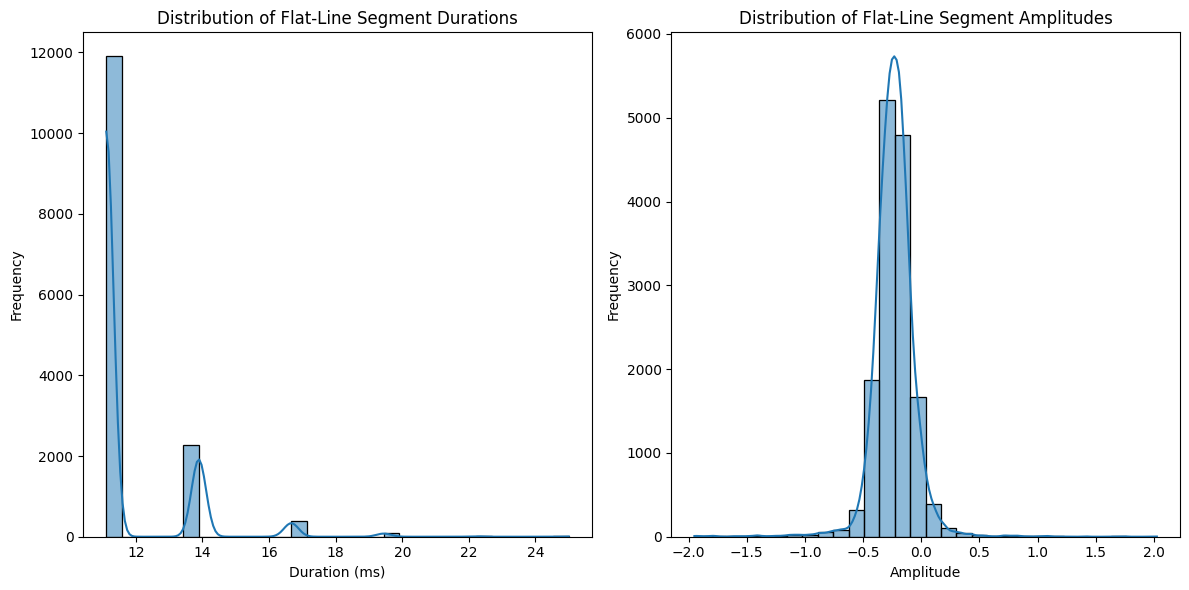

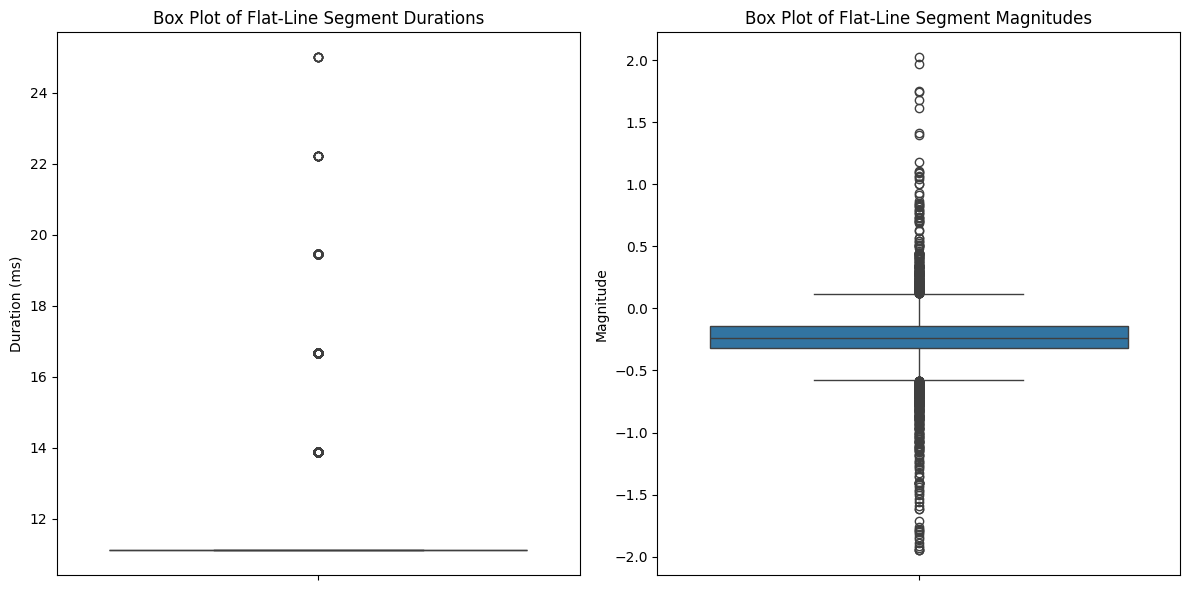

In [ ]:
# Extract durations and magnitudes from all flat segments

durations = [seg[2] for seg in all_flat_segments]
amplitudes = [seg[3] for seg in all_flat_segments]

avgDuration = np.mean(durations, axis=0)
avgAmplitude = np.mean(amplitudes, axis=0)

average_flat_lines_per_file = len(all_flat_segments) / len(record_names)
print(f"Average number of flat lines per file: {average_flat_lines_per_file:.2f}")
print(f"Average duration of flat segments: {avgDuration:.2f} ms")
print(f"Overall Min Duration: {np.min(durations):.2f} ms")
print(f"Overall Max Duration: {np.max(durations):.2f} ms")
print(f"Average amplitude of flat segments: {avgAmplitude:.2f}")
print(f"Overall Min Magnitude: {np.min(magnitudes):.2f}")
print(f"Overall Max Magnitude: {np.max(magnitudes):.2f}")


df = pd.DataFrame({'Duration (ms)': durations, 'Amplitude': amplitudes})

# Create a DataFrame for visualization
import pandas as pd
df = pd.DataFrame({'Duration (ms)': durations, 'Amplitude': amplitudes})

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Duration (ms)'], bins=30, kde=True)
plt.title('Distribution of Flat-Line Segment Durations')
plt.xlabel('Duration (ms)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(df['Amplitude'], bins=30, kde=True)
plt.title('Distribution of Flat-Line Segment Amplitudes')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Plot box plots
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(y=df['Duration (ms)'])
plt.title('Box Plot of Flat-Line Segment Durations')
plt.ylabel('Duration (ms)')


plt.subplot(1, 2, 2)
sns.boxplot(y=df['Amplitude'])
plt.title('Box Plot of Flat-Line Segment Magnitudes')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()